In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
try:
    df = pd.read_csv("CrePosHyperoxiavsCreNegHyperoxia_all_detectable_genes.csv")
except FileNotFoundError:
    print("Error: CSV file not found. Please ensure the file is in the correct directory.")
    exit()

random_state = 42

In [44]:
def categorize_foldchange(foldchange):
    if foldchange > 1:
        return "Up-regulated"
    elif foldchange < -1:
        return "Down-regulated"
    else:
        return "No Change"

df['Regulation'] = df['Foldchange'].apply(categorize_foldchange)

df['CrePos_Mean'] = df[['1posH', '2posH', '3posH', '4posH', '5posH', '6posH']].mean(axis=1)
df['CrePos_Variance'] = df[['1posH', '2posH', '3posH', '4posH', '5posH', '6posH']].var(axis=1)

df['Foldchange_to_Mean'] = df['Foldchange'] / df['CrePos_Mean']
df['PValue_to_Mean'] = df['PValue'] / df['CrePos_Mean']
df['FDR_to_Mean'] = df['FDR'] / df['CrePos_Mean']


In [46]:

print("\n--- Sub-part 1: SVM Classification ---")

X_svm = df[['1posH', '2posH', '3posH', '4posH', '5posH', '6posH', 'CrePos_Mean', 'CrePos_Variance', 'Foldchange_to_Mean', 'PValue_to_Mean', 'FDR_to_Mean']]
y_svm = df['Regulation']


imputer_svm = SimpleImputer(strategy='mean')
X_svm = imputer_svm.fit_transform(X_svm)


scaler_svm = StandardScaler()
X_svm = scaler_svm.fit_transform(X_svm)


X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=random_state, stratify=y_svm)


param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': [0.0001, 0.001, 0.01],
                  'kernel': ['rbf']}

grid_search_svm = GridSearchCV(SVC(class_weight='balanced', random_state=random_state, probability=True),
                               param_grid_svm, verbose=3,
                               scoring='f1_weighted',
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))


grid_search_svm.fit(X_train_svm, y_train_svm)


print("Best parameters found by GridSearchCV:")
print(grid_search_svm.best_params_)
print("Best score found by GridSearchCV:")
print(grid_search_svm.best_score_)


y_pred_svm = grid_search_svm.predict(X_test_svm)


--- Sub-part 1: SVM Classification ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.357 total time=   7.7s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.372 total time=   7.6s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.460 total time=   7.6s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.355 total time=   7.6s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.391 total time=   7.7s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.593 total time=   7.3s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.605 total time=   7.4s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.597 total time=   7.3s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.590 total time=   7.2s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.603 total time=   7.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.875 total time=   6.4s
[CV 2/5] 

In [48]:

y_pred_svm = grid_search_svm.predict(X_test_svm)


y_train_pred_svm = grid_search_svm.predict(X_train_svm)
train_f1_svm = f1_score(y_train_svm, y_train_pred_svm, average='weighted')
test_f1_svm = f1_score(y_test_svm, y_pred_svm, average='weighted')
print(f"SVM Training F1 Score (weighted): {train_f1_svm}")
print(f"SVM Test F1 Score (weighted): {test_f1_svm}")


if train_f1_svm - test_f1_svm > 0.1:  
    print("Warning: The SVM model may be overfitting.")
else:
    print("The SVM model is generalizing well.")



SVM Training F1 Score (weighted): 0.9704337518268769
SVM Test F1 Score (weighted): 0.9645530976405481
The SVM model is generalizing well.


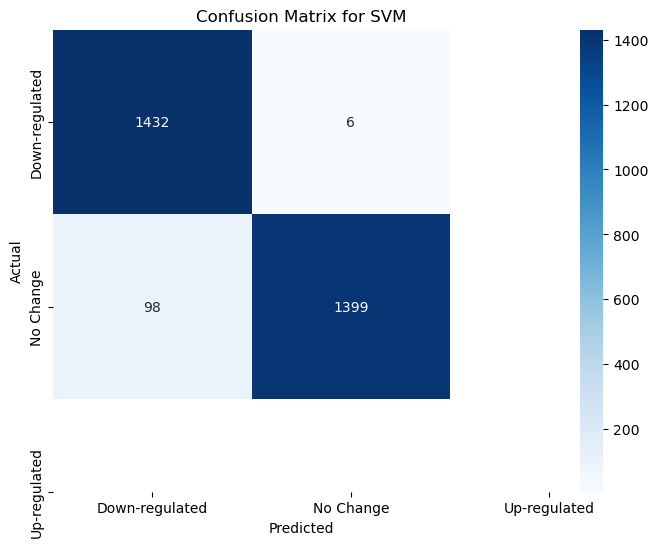

In [50]:

cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down-regulated', 'No Change', 'Up-regulated'], 
            yticklabels=['Down-regulated', 'No Change', 'Up-regulated'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:

print("\n--- Sub-part 2: XGBoost Binary Classification ---")


df['Up_Regulated'] = df['Foldchange'].apply(lambda x: 1 if x > 1 else 0)


X_xgb = df[['1posH', '2posH', '3posH', '4posH', '5posH', '6posH', 'CrePos_Mean', 'CrePos_Variance', 'Foldchange_to_Mean', 'PValue_to_Mean', 'FDR_to_Mean']]
y_xgb = df['Up_Regulated']


imputer_xgb = SimpleImputer(strategy='mean')
X_xgb = imputer_xgb.fit_transform(X_xgb)


scaler_xgb = StandardScaler()
X_xgb = scaler_xgb.fit_transform(X_xgb)


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=random_state, stratify=y_xgb)


param_grid_xgb = {
    'n_estimators': [3, 5],
    'max_depth': [1, 2],
    'learning_rate': [0.0001, 0.001],
    'reg_alpha': [0.9, 0.95],
    'reg_lambda': [0.9, 0.95]
}

grid_search_xgb = GridSearchCV(XGBClassifier(random_state=random_state,
                                            use_label_encoder=False,
                                            eval_metric='logloss',
                                            scale_pos_weight=(len(y_xgb) - sum(y_xgb)) / sum(y_xgb)),
                            param_grid_xgb, verbose=3,
                            scoring='f1',
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))


grid_search_xgb.fit(X_train_xgb, y_train_xgb)


print("Best parameters found by GridSearchCV:")
print(grid_search_xgb.best_params_)
print("Best score found by GridSearchCV:")
print(grid_search_xgb.best_score_)


y_pred_xgb = grid_search_xgb.predict(X_test_xgb)



--- Sub-part 2: XGBoost Binary Classification ---
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.998 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.95;, score=0.998 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=3, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.998 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.95, reg_lambda=0.9;, score=0.998 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.95, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=5, reg_alpha=0.95, reg_lambda=0.9;, score=0

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV 5/5] END learning_rate=0.0001, max_depth=2, n_estimators=3, reg_alpha=0.95, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=1.000

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.95;, score=0.998 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.95;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=3, reg_alpha=0.95, reg_lambda=0.95;, score=0.997

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=5, reg_alpha=0.95, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=3, reg_alpha=0.9, reg_lambda=0.95;, score=1.000 total t

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.9;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.997 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.9, reg_lambda=0.95;, score=0.999 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=5, reg_alpha=0.95, reg_lambda=0.9;, score=0.999 total

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

In [54]:

y_train_pred_xgb = grid_search_xgb.predict(X_train_xgb)
train_f1_xgb = f1_score(y_train_xgb, y_train_pred_xgb)
test_f1_xgb = f1_score(y_test_xgb, y_pred_xgb)
print(f"XGBoost Training F1 Score: {train_f1_xgb}")
print(f"XGBoost Test F1 Score: {test_f1_xgb}")


if train_f1_xgb - test_f1_xgb > 0.1:  # Adjust threshold as needed
    print("Warning: The XGBoost model may be overfitting.")
else:
    print("The XGBoost model is generalizing well.")


XGBoost Training F1 Score: 0.9978231748158071
XGBoost Test F1 Score: 0.9966487935656837
The XGBoost model is generalizing well.


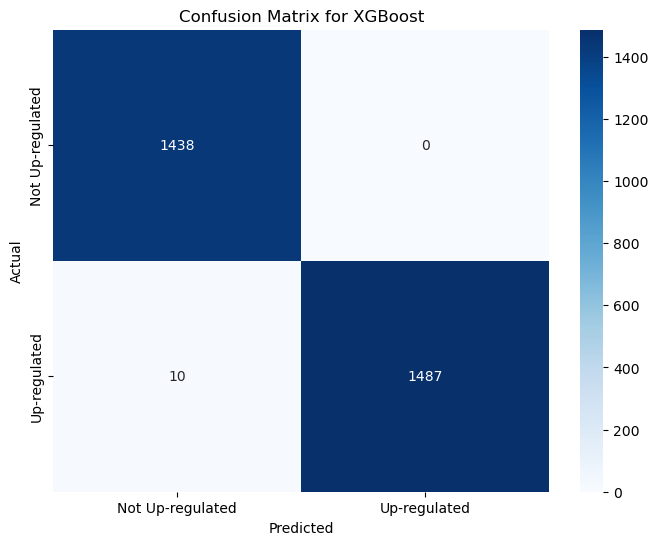

In [56]:

cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Up-regulated', 'Up-regulated'], 
            yticklabels=['Not Up-regulated', 'Up-regulated'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [58]:

print("\n--- Sub-part 3: KNN Classification ---")


X_knn = df[['1posH', '2posH', '3posH', '4posH', '5posH', '6posH', 'CrePos_Mean', 'CrePos_Variance', 'Foldchange_to_Mean', 'PValue_to_Mean', 'FDR_to_Mean']]
y_knn = df['Regulation']


imputer_knn = SimpleImputer(strategy='mean')
X_knn = imputer_knn.fit_transform(X_knn)


scaler_knn = StandardScaler()
X_knn = scaler_knn.fit_transform(X_knn)


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=random_state, stratify=y_knn)


param_grid_knn = {'n_neighbors': [35, 40, 45],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}


grid_search_knn = GridSearchCV(KNeighborsClassifier(),
                               param_grid_knn, verbose=3,
                               scoring='accuracy',
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))


grid_search_knn.fit(X_train_knn, y_train_knn)



--- Sub-part 3: KNN Classification ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END algorithm=auto, n_neighbors=35, weights=uniform;, score=0.950 total time=   0.1s
[CV 2/5] END algorithm=auto, n_neighbors=35, weights=uniform;, score=0.942 total time=   0.1s
[CV 3/5] END algorithm=auto, n_neighbors=35, weights=uniform;, score=0.946 total time=   0.1s
[CV 4/5] END algorithm=auto, n_neighbors=35, weights=uniform;, score=0.943 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=35, weights=uniform;, score=0.952 total time=   0.1s
[CV 1/5] END algorithm=auto, n_neighbors=35, weights=distance;, score=0.953 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=35, weights=distance;, score=0.943 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=35, weights=distance;, score=0.949 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=35, weights=distance;, score=0.946 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=35, wei

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [35, 40, 45],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [60]:

print("Best parameters found by GridSearchCV:")
print(grid_search_knn.best_params_)
print("Best score found by GridSearchCV:")
print(grid_search_knn.best_score_)


Best parameters found by GridSearchCV:
{'algorithm': 'auto', 'n_neighbors': 35, 'weights': 'distance'}
Best score found by GridSearchCV:
0.9487988943803718


In [62]:

y_pred_knn = grid_search_knn.predict(X_test_knn)


y_train_pred_knn = grid_search_knn.predict(X_train_knn)
train_accuracy_knn = accuracy_score(y_train_knn, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test_knn, y_pred_knn)
print(f"KNN Training Accuracy: {train_accuracy_knn}")
print(f"KNN Test Accuracy: {test_accuracy_knn}")


if train_accuracy_knn - test_accuracy_knn > 0.1:  # Adjust threshold as needed
    print("Warning: The KNN model may be overfitting.")
else:
    print("The KNN model is generalizing well.")



KNN Training Accuracy: 1.0
KNN Test Accuracy: 0.9499148211243612
The KNN model is generalizing well.


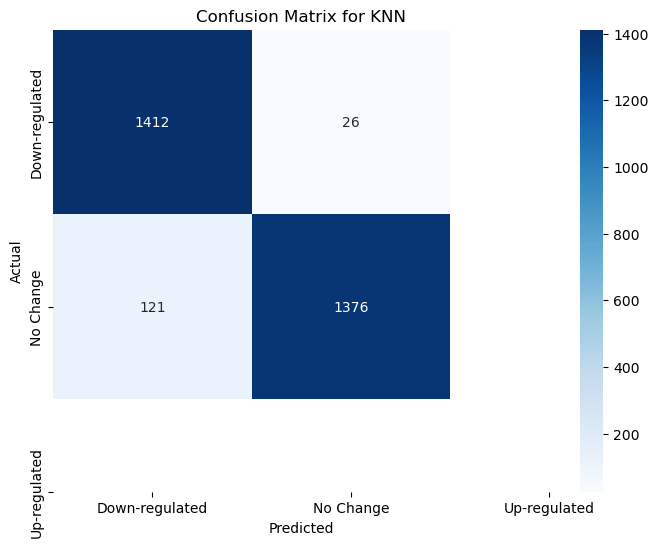

In [64]:
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down-regulated', 'No Change', 'Up-regulated'], 
            yticklabels=['Down-regulated', 'No Change', 'Up-regulated'])
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

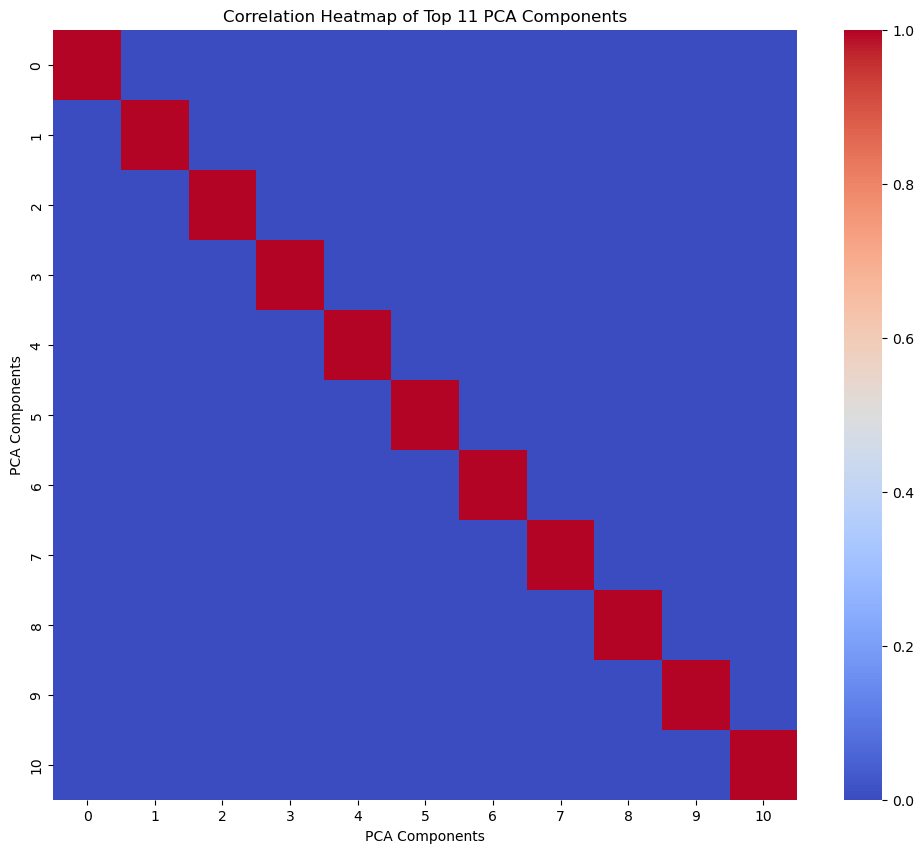

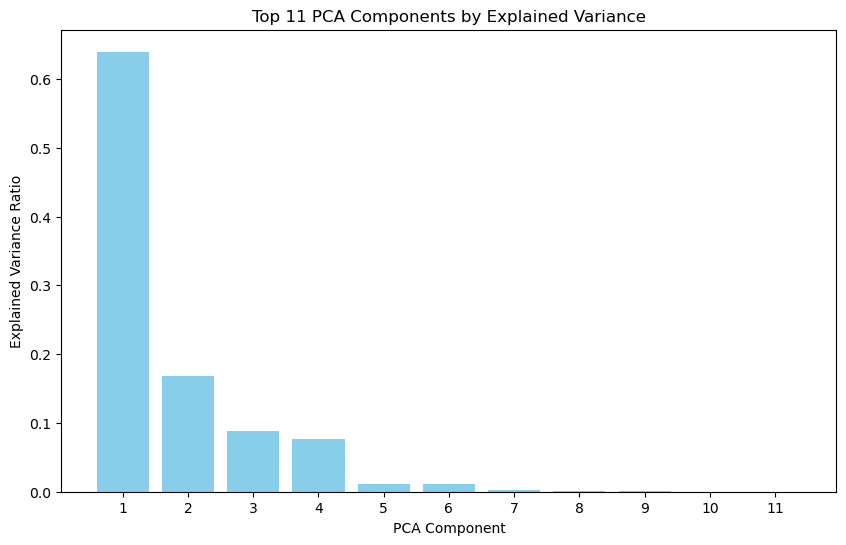

In [66]:

pca = PCA(n_components=11)  
X_pca = pca.fit_transform(X_svm)


corr_matrix = np.corrcoef(X_pca, rowvar=False)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap of Top 11 PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('PCA Components')
plt.show()


explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, 12), explained_variance[:11], color='skyblue') 
plt.title('Top 11 PCA Components by Explained Variance')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 12))
plt.show()

<Figure size 1200x800 with 0 Axes>

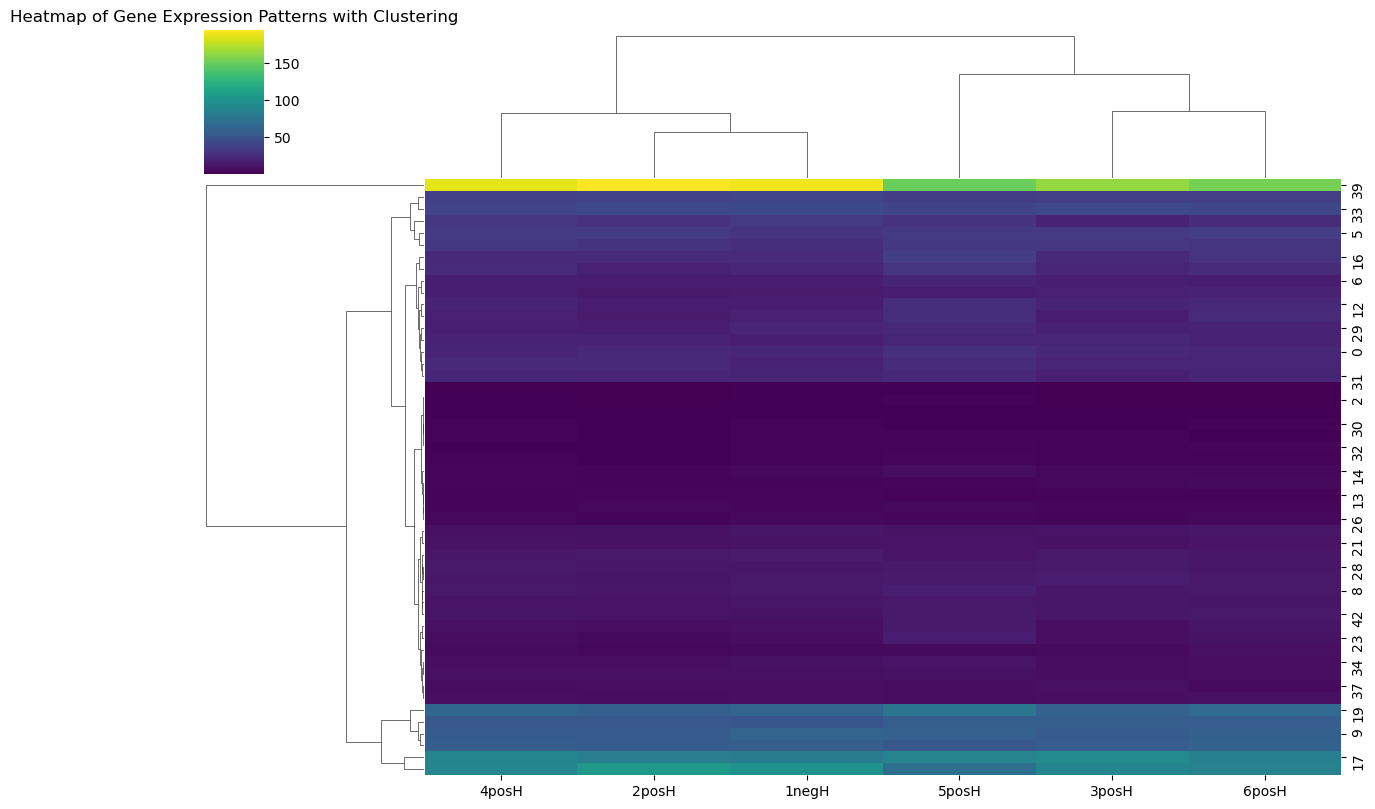

In [68]:

subset_data = df.iloc[:50, 6:12]  # Use columns 6 to 11 (expression levels under "CrePos Hyperoxia")


row_cluster = linkage(subset_data, method='average', metric='euclidean')
col_cluster = linkage(subset_data.T, method='average', metric='euclidean')


plt.figure(figsize=(12, 8))
sns.clustermap(subset_data, row_linkage=row_cluster, col_linkage=col_cluster, cmap='viridis', figsize=(12, 8))
plt.title('Heatmap of Gene Expression Patterns with Clustering')
plt.show()


In [70]:

print("\n--- Ensemble: VotingClassifier ---")

svm_best_estimator = grid_search_svm.best_estimator_
xgb_best_estimator = grid_search_xgb.best_estimator_
knn_best_estimator = grid_search_knn.best_estimator_

voting_clf = VotingClassifier(estimators=[('svm', svm_best_estimator), ('xgb', xgb_best_estimator), ('knn', knn_best_estimator)], voting='soft')


voting_clf.fit(X_train_svm, y_train_svm)


y_pred_ensemble = voting_clf.predict(X_test_svm)


--- Ensemble: VotingClassifier ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [72]:

f1_ensemble = f1_score(y_test_svm, y_pred_ensemble, average='weighted')
print(f"Ensemble F1 Score (weighted): {f1_ensemble}")

Ensemble F1 Score (weighted): 0.971381107154325
